# Analysis Prep: Reading Data from Relational Database

In [1]:
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

import matplotlib.pyplot as plt

In [2]:
engine = create_engine('sqlite:///../resources/database/hawaii.sqlite')

In [3]:
inspector_gadget = inspect(engine)

In [4]:
inspector_gadget.get_table_names()

['measurement', 'station']

In [5]:
print("tablename: measurement \n")
for piece in inspector_gadget.get_columns(table_name='measurement'):
    print(piece['name'], piece['type'])

tablename: measurement 

id INTEGER
station VARCHAR(15)
date TEXT
prcp FLOAT
tobs INTEGER


In [6]:
print("tablename: station \n")
for piece in inspector_gadget.get_columns(table_name='station'):
    print(piece['name'], piece['type'])

tablename: station 

id INTEGER
station VARCHAR(15)
name VARCHAR(75)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
Base = automap_base()

In [8]:
Base.prepare(engine=engine, reflect=True)

In [9]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
session = Session(bind=engine)

# Precipitation Analysis

In [11]:
import pandas as pd
import numpy as np

In [12]:
last_12_mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-01', Measurement.date <= '2017-08-31').all()

In [13]:
prec_df = pd.DataFrame(last_12_mo)
prec_df.date = pd.to_datetime(prec_df.date, format='%Y-%m-%d').dt.date
prec_df.set_index('date', inplace=True)

In [14]:
prec_df.rename(columns={'prcp':'precipitation'}, inplace=True)

In [15]:
prec_df.head()

,precipitation
date,
2016-08-01,0.08
2016-08-02,0.05
2016-08-03,0.00
2016-08-04,0.04
2016-08-05,0.01


## HELP!

#### bar plot using the dataframe with one index, in date date-type %Y-%m-%d,  and one column of values

In [16]:
print(f"Max Precipitation: {prec_df.precipitation.max()}, Min Precipitation: {prec_df.precipitation.min()}")

Max Precipitation: 6.7, Min Precipitation: 0.0


In [17]:
len(prec_df)

2372

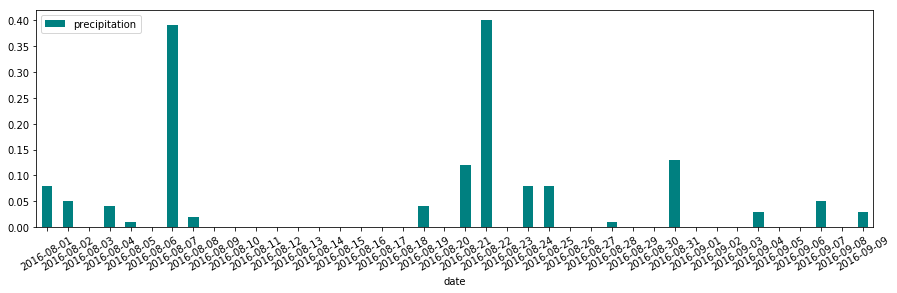

In [18]:
prec_df[:40].plot.bar(figsize=(15,4), rot=30, color='teal')
plt.legend(loc=2)
plt.show()

In [19]:
# import datetime

In [20]:
# base = datetime.datetime(2016, 8, 1)
# arr = np.array([base + datetime.timedelta(months=i) for i in xrange(12)])
# arr

In [21]:
# dates = np.array(['2016-08-01','2016-09-01','2016-10-01','2016-11-01','2016-12-01','2017-01-01','2017-02-01','2017-03-01',
#          '2017-04-01','2017-05-01','2017-06-01','2017-07-01','2017-08-01'], dtype='datetime64')

#### same bar plot, removing all the text in the xaxis

In [22]:
# df.plot.bar(yticks=np.arange(0,5), ylim=((0,4)))
# ax1 = plt.axes()
# x_axis = ax1.axes.get_xaxis()
# x_axis.set_visible(False)

# plt.show()


#### plt monthly

In [23]:
# import datetime
# from dateutil.rrule import rrule, MONTHLY

In [24]:
# d1 = datetime.date(2016,8,1)
# d2 = datetime.date(2017,8,31)

# dates = [dt.strftime('%Y-%m-%d') for dt in rrule(MONTHLY, dtstart=d1, until=d2)]
# dates

In [25]:
# plt.close('all')

# Station Analysis

In [26]:
station_count = session.query(Station).count()
print(f"The number of weather stations on Honolulu Hawaii are {station_count}.")

The number of weather stations on Honolulu Hawaii are 9.


In [27]:
station_observation_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(-func.count(Measurement.station)).all()
for station, count in station_observation_count:
    print(f"Station: {station}, Number of Observations: {count}")

print("\n" + "-"*55 + "\n")
print(f"The weather station with the highest amount of observations is {station_observation_count[0][0]} with {station_observation_count[0][1]} observations.")

Station: USC00519281, Number of Observations: 2772
Station: USC00519397, Number of Observations: 2724
Station: USC00513117, Number of Observations: 2709
Station: USC00519523, Number of Observations: 2669
Station: USC00516128, Number of Observations: 2612
Station: USC00514830, Number of Observations: 2202
Station: USC00511918, Number of Observations: 1979
Station: USC00517948, Number of Observations: 1372
Station: USC00518838, Number of Observations: 511

-------------------------------------------------------

The weather station with the highest amount of observations is USC00519281 with 2772 observations.


#### Last 12 months of temperature observation data

In [28]:
last_12_mo = session.query(Measurement.station, Measurement.tobs, Measurement.date).filter(Measurement.date >= '2016-08-01', Measurement.date <= '2017-08-31').all()

In [29]:
largest_count = pd.DataFrame(last_12_mo)[['station','tobs']].groupby('station').count().sort_values('tobs', ascending=False)[:1].index.item()

In [30]:
largest_station = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date >= '2016-08-01', Measurement.date <= '2017-08-31', Measurement.station == largest_count).all()

In [31]:
df = pd.DataFrame(largest_station)

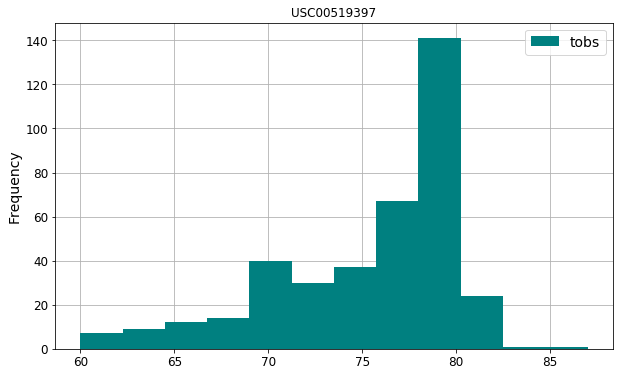

In [32]:
df.plot.hist(bins=12, zorder=2, title=largest_count, grid=True, figsize=(10,6), fontsize=12, color='teal')
plt.ylabel('Frequency', size=14)
plt.legend(loc=1, prop={'size': 14})
plt.show()

# Temperature Analysis

In [33]:
def calc_temps(start_date, end_date):
    results = session.query(Measurement.tobs).filter(Measurement.date >= start_date, Measurement.date <= end_date).all()
    results_ra = np.ravel(results)
    
    minimum = np.min(results_ra)
    average = np.average(results_ra)
    maximum = np.max(results_ra)
    return minimum, average, maximum

In [34]:
last_year_min, last_year_avg, last_year_max = calc_temps('2017-01-01', '2018-01-01')

In [35]:
last_year_min

58

In [36]:
last_year_max

87

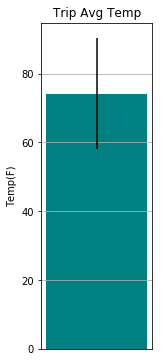

In [37]:
fig, ax = plt.subplots(figsize=(2,6))
ax.bar(1, last_year_avg, yerr=[(last_year_min-last_year_avg, last_year_max-last_year_avg)], color='teal')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
plt.grid()
plt.show()

# Vacation Rain and Temperature Analysis

In [38]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
rainfall_ly = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date >= '2016-08-01', Measurement.date <= '2017-08-31').group_by(Measurement.station).all()

print("Total Rainfall Last Year")
for station, rainfall in rainfall_ly:
    print(f"Station: {station}, Total Rainfall: {rainfall}.")

Total Rainfall Last Year
Station: USC00513117, Total Rainfall: 54.39000000000004.
Station: USC00514830, Total Rainfall: 35.379999999999995.
Station: USC00516128, Total Rainfall: 165.75999999999996.
Station: USC00517948, Total Rainfall: 4.77.
Station: USC00519281, Total Rainfall: 80.06000000000006.
Station: USC00519397, Total Rainfall: 17.23999999999999.
Station: USC00519523, Total Rainfall: 40.14.


In [39]:
def daily_norms(date):
    diced = date.split("-")
    if int(diced[1]) < 10 and len(diced[1]) < 2:
        date2 = f"0{diced[1]}"
        date = f"{diced[0]}-{date2}"
    
    results = session.query(Measurement.tobs).filter(Measurement.date.like(f"%{date}")).all()
    results_ra = np.ravel(results)
    
    minimum = np.min(results_ra)
    average = np.average(results_ra)
    maximum = np.max(results_ra)
    return minimum, average, maximum

In [40]:
travel_dates = [f"2018-06-{i+1}" for i in range(7)]

In [41]:
norms = []
for date in travel_dates:
    minimum, average, maximum = daily_norms(date[5:]) 
    norms.append((date, minimum, average, maximum))

In [42]:
vacation_df = pd.DataFrame(norms, columns=['date','tmin','tavg','tmax']).set_index('date')

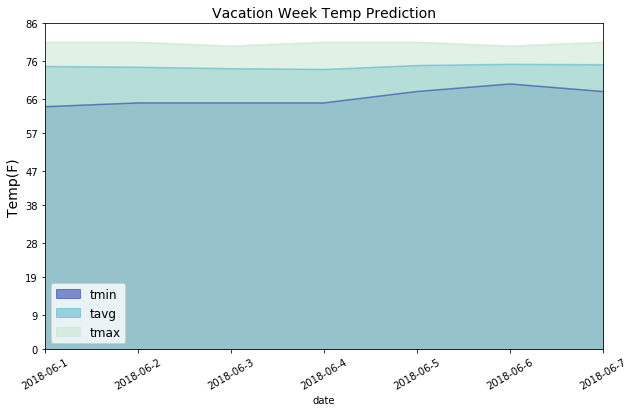

In [43]:
pal = ["#1127a0", "#48b1c9", "#c5e5cc"]

vacation_df.plot(kind='area', color=pal, stacked=False, yticks=np.linspace(0,vacation_df.tmax.max()+5,10, dtype=int), rot=30, figsize=(10,6))
plt.title('Vacation Week Temp Prediction', size=14)
plt.ylabel('Temp(F)', size=14)
plt.legend(loc=3, prop={'size': 12})
plt.show()

In [44]:
plt.close('all')